## **6. PyTorch GPU训练**

### **6.1 GPU训练方式1**

在使用GPU进行训练时，主要涉及三个核心部分：网络模型、数据（包括输入和标注）、以及损失函数。这三个组成部分都需要被传输到GPU上（调用`.cuda`函数），以利用GPU的高并行处理能力来加速模型的训练过程。

- `network = network.cuda()`
- `loss_fn = loss_fn.cuda()`
- `imgs = imgs.cuda()`
- `targets = targets.cuda()`

In [7]:
import time
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter


In [8]:
# 准备数据集
train_data = torchvision.datasets.CIFAR10('./data', train=True, 
                                          transform=torchvision.transforms.ToTensor(),
                                          download=False)
test_data = torchvision.datasets.CIFAR10('./data', train=False, 
                                         transform=torchvision.transforms.ToTensor(),
                                         download=False)

# 查看训练数据集、测试数据集分别有多少张图片
print("Train Dataset's Size: {}".format(len(train_data)))
print("Test Dataset's Size: {}".format(len(test_data)))
# len(train_data), len(test_data)

Train Dataset's Size: 50000
Test Dataset's Size: 10000


In [9]:
# 没有cuda方法，不可行
# train_data.cuda()

In [10]:
# 利用 DataLoader 来加载数据集，正确传递数据集对象
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [11]:
# 搭建神经网络
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, 5, 1, 2),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 32, 5, 1, 2),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 5, 1, 2),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64*4*4, 64),
            nn.Linear(64, 10), 
        )
    
    def forward(self, x):
        x = self.model(x)
        return x

In [12]:
# 创建网络模型
network = NeuralNetwork()
# 将网络模型转移到cuda上面去
if torch.cuda.is_available():
    network = network.cuda()
# 损失函数
loss_fn = nn.CrossEntropyLoss()
# 将损失函数转移到cuda上面去
if torch.cuda.is_available():
    loss_fn = loss_fn.cuda()
# 学习率
# lr = 0.01
lr = 1e-2   # 1 × 10^(-2)
# 优化器
optimizer = torch.optim.SGD(network.parameters(), lr=lr)

# 设置训练网络的一些参数
# 记录训练的次数
total_train_step = 0
# 记录测试的次数
total_test_step = 0
# 训练的轮数
epoch = 10

In [13]:
# 添加tensorboard
writer = SummaryWriter('./log')

for i in range(epoch):
    print("----------第 {} 轮训练开始----------".format(i+1))
    
    # 训练步骤开始
    network.train()
    for data in train_dataloader:
        imgs, targets = data
        # 将训练数据转移到cuda上面去
        if torch.cuda.is_available():
            imgs = imgs.cuda()
            targets = targets.cuda()
        outputs = network(imgs)
        loss = loss_fn(outputs, targets)
        
        # 优化器调优
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_train_step += 1
        # 训练步骤逢百的时候才打印
        if total_train_step % 100 == 0:
            print("训练次数：{}, Loss：{}".format(total_train_step, loss.item()))
            writer.add_scalar('Train_Loss', loss.item(), total_train_step)
        # print("训练次数：{}, Loss：{}".format(total_train_step, loss.item()))
        # writer.add_scalar('Train_Loss', loss.item(), total_train_step)
        
    # 测试步骤开始（每轮训练后都查看在测试数据集上的loss情况）
    network.eval()
    total_test_loss = 0
    total_accuracy = 0
    with torch.no_grad():   # 没有梯度计算，节约内存
        for data in test_dataloader:
            imgs, targets = data
            # 将测试数据转移到cuda上面去
            if torch.cuda.is_available():
                imgs = imgs.cuda()
                targets = targets.cuda()
            outputs = network(imgs)
            loss = loss_fn(outputs, targets)
            total_test_loss += loss.item()
            accuracy = (outputs.argmax(1) == targets).sum()
            total_accuracy += accuracy
    
    print("整体测试集上的loss: {}".format(total_test_loss))
    print("整体测试集上的accuracy: {}".format(total_accuracy/len(test_data)))
    
    writer.add_scalar("Test_Accuracy", total_accuracy/len(test_data), total_test_step)
    writer.add_scalar("Test_Loss", total_test_loss, total_test_step)
    total_test_step += 1
    
    # 保存每一轮训练的模型
    torch.save(network, "./model/network_{}.path".format(i))
    
writer.close()

----------第 1 轮训练开始----------
训练次数：100, Loss：2.2997796535491943
训练次数：200, Loss：2.2759435176849365
训练次数：300, Loss：2.262472152709961
训练次数：400, Loss：2.114814519882202
训练次数：500, Loss：2.124800205230713
训练次数：600, Loss：1.9692034721374512
训练次数：700, Loss：1.906623363494873
整体测试集上的loss: 307.4825608730316
整体测试集上的accuracy: 0.30239999294281006
----------第 2 轮训练开始----------
训练次数：800, Loss：2.151048183441162
训练次数：900, Loss：1.9568901062011719
训练次数：1000, Loss：2.2294890880584717
训练次数：1100, Loss：1.9197630882263184
训练次数：1200, Loss：1.8405725955963135
训练次数：1300, Loss：1.8432279825210571
训练次数：1400, Loss：1.6981310844421387
训练次数：1500, Loss：1.9220595359802246
整体测试集上的loss: 270.62088787555695
整体测试集上的accuracy: 0.3836999833583832
----------第 3 轮训练开始----------
训练次数：1600, Loss：1.7893480062484741
训练次数：1700, Loss：1.6122870445251465
训练次数：1800, Loss：1.7068958282470703
训练次数：1900, Loss：1.8294062614440918
训练次数：2000, Loss：1.5743523836135864
训练次数：2100, Loss：1.8221369981765747
训练次数：2200, Loss：1.553418755531311
训练次数：2300, Loss：1.8

### **6.2 GPU训练方式2**

首先检查系统是否有CUDA支持的GPU可用，如果有，则使用GPU；如果没有，退回到CPU。这样可以确保代码的兼容性和灵活性。

- `device = torch.device("cuda" if torch.cuda.is_available() else "cpu")`

如果有多张显卡的话，可以按以下方式设置：
- `device0 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")`

以下是如何将网络模型、损失函数、输入图像和标签目标传递到 GPU 上的具体步骤
- `network = network.to(device)`
- `loss_fn = loss_fn.to(device)`
- `imgs = imgs.to(device)`
- `targets = targets.to(device)`

In [14]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

In [15]:
# 准备数据集
train_data = torchvision.datasets.CIFAR10('./data', train=True, 
                                          transform=torchvision.transforms.ToTensor(),
                                          download=False)
test_data = torchvision.datasets.CIFAR10('./data', train=False, 
                                         transform=torchvision.transforms.ToTensor(),
                                         download=False)

# 查看训练数据集、测试数据集分别有多少张图片
print("Train Dataset's Size: {}".format(len(train_data)))
print("Test Dataset's Size: {}".format(len(test_data)))
# len(train_data), len(test_data)

Train Dataset's Size: 50000
Test Dataset's Size: 10000


In [16]:
# 利用 DataLoader 来加载数据集，正确传递数据集对象
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

# 定义训练的设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
# 搭建神经网络
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, 5, 1, 2),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 32, 5, 1, 2),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 4, 1, 2),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64*4*4, 64),
            nn.Linear(64, 10), 
        )
    
    def forward(self, x):
        x = self.model(x)
        return x

In [18]:
# 创建网络模型
network = NeuralNetwork()
network = network.to(device)
# 损失函数
loss_fn = nn.CrossEntropyLoss()
loss_fn = loss_fn.to(device)
# 学习率
# lr = 0.01
lr = 1e-2   # 1 × 10^(-2)
# 优化器
optimizer = torch.optim.SGD(network.parameters(), lr=lr)

# 设置训练网络的一些参数
# 记录训练的次数
total_train_step = 0
# 记录测试的次数
total_test_step = 0
# 训练的轮数
epoch = 30

In [19]:
# 添加tensorboard
writer = SummaryWriter('./log')

for i in range(epoch):
    print("----------第 {} 轮训练开始----------".format(i+1))
    
    # 训练步骤开始
    network.train()
    for data in train_dataloader:
        imgs, targets = data
        imgs = imgs.to(device)
        targets = targets.to(device)
        outputs = network(imgs)
        loss = loss_fn(outputs, targets)
        
        # 优化器调优
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_train_step += 1
        # 训练步骤逢百的时候才打印
        if total_train_step % 100 == 0:
            print("训练次数：{}, Loss：{}".format(total_train_step, loss.item()))
            writer.add_scalar('Train_Loss', loss.item(), total_train_step)
        # print("训练次数：{}, Loss：{}".format(total_train_step, loss.item()))
        # writer.add_scalar('Train_Loss', loss.item(), total_train_step)
        
    # 测试步骤开始（每轮训练后都查看在测试数据集上的loss情况）
    network.eval()
    total_test_loss = 0
    total_accuracy = 0
    with torch.no_grad():   # 没有梯度计算，节约内存
        for data in test_dataloader:
            imgs, targets = data
            imgs = imgs.to(device)
            targets = targets.to(device)
            outputs = network(imgs)
            loss = loss_fn(outputs, targets)
            total_test_loss += loss.item()
            accuracy = (outputs.argmax(1) == targets).sum()
            total_accuracy += accuracy
    
    print("整体测试集上的loss: {}".format(total_test_loss))
    print("整体测试集上的accuracy: {}".format(total_accuracy/len(test_data)))
    
    writer.add_scalar("Test_Accuracy", total_accuracy/len(test_data), total_test_step)
    writer.add_scalar("Test_Loss", total_test_loss, total_test_step)
    total_test_step += 1
    
    # 保存每一轮训练的模型
    torch.save(network, "./model/network_{}.path".format(i))
    
writer.close()

----------第 1 轮训练开始----------
训练次数：100, Loss：2.2918660640716553
训练次数：200, Loss：2.2917041778564453
训练次数：300, Loss：2.2138068675994873
训练次数：400, Loss：2.192349672317505
训练次数：500, Loss：2.1567959785461426
训练次数：600, Loss：2.079293727874756
训练次数：700, Loss：2.0084331035614014
整体测试集上的loss: 330.87653601169586
整体测试集上的accuracy: 0.25040000677108765
----------第 2 轮训练开始----------
训练次数：800, Loss：2.1151487827301025
训练次数：900, Loss：1.976540446281433
训练次数：1000, Loss：1.83774733543396
训练次数：1100, Loss：1.9073152542114258
训练次数：1200, Loss：1.8058167695999146
训练次数：1300, Loss：2.0304219722747803
训练次数：1400, Loss：1.651041865348816
训练次数：1500, Loss：1.5937073230743408
整体测试集上的loss: 271.05830514431
整体测试集上的accuracy: 0.3986999988555908
----------第 3 轮训练开始----------
训练次数：1600, Loss：1.9013532400131226
训练次数：1700, Loss：1.7818435430526733
训练次数：1800, Loss：1.8231772184371948
训练次数：1900, Loss：1.6938292980194092
训练次数：2000, Loss：1.7007107734680176
训练次数：2100, Loss：1.7705998420715332
训练次数：2200, Loss：1.6597399711608887
训练次数：2300, Loss：1.619

### **6.3 完整的模型验证**

利用已经训练好的模型，然后给模型一个输入。

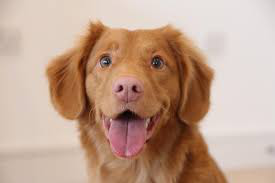

In [20]:
from PIL import Image

image_path1 = "./image/6-1.png"
image_path2 = "./image/6-2.png"

img1 = Image.open(image_path1)
img2 = Image.open(image_path2)
img1

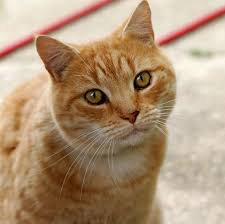

In [21]:
img2

In [22]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.ToTensor()])

img1 = transform(img1)
img2 = transform(img2)
img1.shape, img2.shape

(torch.Size([3, 32, 32]), torch.Size([3, 32, 32]))

In [23]:
# 搭建神经网络
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, 5, 1, 2),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 32, 5, 1, 2),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 4, 1, 2),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64*4*4, 64),
            nn.Linear(64, 10), 
        )
    
    def forward(self, x):
        x = self.model(x)
        return x

# 导入模型
model = torch.load("./model/network_29.path")
model

/tmp/ipykernel_1473/1671408148.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("./model/network_29.path")


NeuralNetwork(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1024, out_features=64, bias=True)
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [34]:
# 如果加载的模型是用GPU训练保存的，输入的图片得送给GPU测试
# 确定设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 确保模型在正确的设备上
model = model.to(device)
model.eval()

# 创建数据张量，并确保其也在正确的设备上
img1 = torch.reshape(img1, (1, 3, 32, 32)).to(device)
img2 = torch.reshape(img2, (1, 3, 32, 32)).to(device)

# 使用不计算梯度的环境来进行预测，以节省内存和计算资源
with torch.no_grad():
    output1 = model(img1)
    output2 = model(img2)

output1, output2

(tensor([[-5.3322, -7.7275,  2.1610,  5.2564,  0.9670,  8.6837,  1.9294,  2.6598,
          -1.7781, -3.2944]], device='cuda:0'),
 tensor([[-2.0266, -8.2409,  3.4401,  4.2733,  2.5817,  4.9797,  2.1138,  4.2570,
          -3.8064, -6.7575]], device='cuda:0'))

In [35]:
output1.argmax(1), output2.argmax(1)

(tensor([5], device='cuda:0'), tensor([5], device='cuda:0'))

In [36]:
train_data.classes[5], train_data.classes[3]

('dog', 'cat')